In [12]:
# Design CIS 2D color router
# Resoultion 25 

# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 2

Air = mp.Medium(index=1.0)
SiN = mp.Medium(epsilon=4)
SiO2 = mp.Medium(epsilon=2.1)
TiO2 = mp.Medium(epsilon=7)
SiPD = mp.Medium(epsilon=5)

# 설계 공간
design_region_width = 9 # 디자인 영역 너비
design_region_height = 4 # 디자인 영역 높이

# 해상도 및 사이즈 설정
resolution = 50 
gapop = 0
air_gap = 0
dti = 0.4
subpixelsize = design_region_width/3 - dti
if gapop == 1:
    air_gap = dti/2
PDsize = 2
Lpml = 1 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Y)]
Sourcespace = 1

# 전체 공간
Sx = design_region_width
Sy = PDsize + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy)

# structure load
structure_weight = np.loadtxt('lastdesign.txt')

# 파장, 주파수 설정
wavelengths = np.linspace(0.40*um_scale, 0.70*um_scale, 31) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# constraint 설정
minimum_length = 0.025  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

# Source 설정

width = 0.4

fcen_red = 1/(0.65*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.55*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.45*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = mp.Vector3(0, Sy/ 2 - Lpml - Sourcespace / 2, 0) # Source 위치
source_size = mp.Vector3(Sx, 0, 0)

source = [mp.Source(src_0, component=mp.Ez, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ez, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ez, size=source_size, center=source_center,),]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1


# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_MEAN")
design_variables.update_weights(structure_weight)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, - Sy /2 + PDsize + design_region_height / 2, 0),
        size=mp.Vector3(design_region_width-air_gap*2, design_region_height, 0),
    ),
)
    

# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
    
    mp.Block(
        center=mp.Vector3(0, -Sy/2 + PDsize/2, 0), size=mp.Vector3(Sx, PDsize, 0), material=SiO2
    ),
    
    # DTI가 있을 경우 사용
    mp.Block(
        center=mp.Vector3(-design_region_width/3, -Sy/2 + PDsize/2, 0), size=mp.Vector3(subpixelsize, 2, 0), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(0, -Sy/2 + PDsize/2, 0), size=mp.Vector3(subpixelsize, 2, 0), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(design_region_width/3, -Sy/2 + PDsize/2, 0), size=mp.Vector3(subpixelsize, 2, 0), material=SiPD
    )
]

# Meep simulation 세팅
sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0) # bloch boundary
)

     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


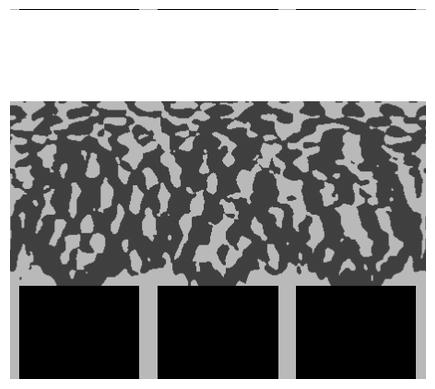

In [13]:
###############################################################################################################################
# ## 2. Optimization Environment


# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width/3, -Sy/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(0, -Sy/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width/3, -Sy/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0)


# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ez,yee_grid=True)

FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ez,yee_grid=True)

FourierFields_2= mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ez,yee_grid=True)

ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,]

# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J_0(fields_0, fields_1, fields_2):
    red = npa.sum(npa.abs(fields_0[21:30,1]) ** 2)
    green = npa.sum(npa.abs(fields_1[11:20,1]) ** 2) 
    blue = npa.sum(npa.abs(fields_2[1:10,1]) ** 2) 
    
    redfactor = 1.5
    greenfactor = 1.1
    bluefactor = 2
    return bluefactor * blue + greenfactor * green + redfactor * red

# optimization 설정
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-1, # 모니터에 남아있는 필드 값의 비율
)
# plt.fill([design_region_width/6+dti/2, design_region_width/6+dti/2, design_region_width/2-dti/2, design_region_width/2-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='blue', alpha=0.5)
# plt.fill([-design_region_width/6+dti/2, -design_region_width/6+dti/2, design_region_width/6-dti/2, design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='green', alpha=0.5)
# plt.fill([-design_region_width/2+dti/2, -design_region_width/2+dti/2, -design_region_width/6-dti/2, -design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='red', alpha=0.5)
opt.plot2D(    source_parameters={'alpha':0},
               boundary_parameters={'alpha':0},
               # eps_parameters={'alpha':0},
               # field_parameters={'colorbar':True}
          )
plt.axis("off")

plt.savefig(design_dir+"Lastdesign.png")


-----------
Initializing structure...
time for choose_chunkdivision = 4.88758e-05 s
Working in 2D dimensions.
Computational cell is 9 x 8 x 0 with resolution 50
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.918256 s
-----------


FloatProgress(value=0.0, description='0% done ', max=50.0)

run 0 finished at t = 50.0 (5000 timesteps)
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


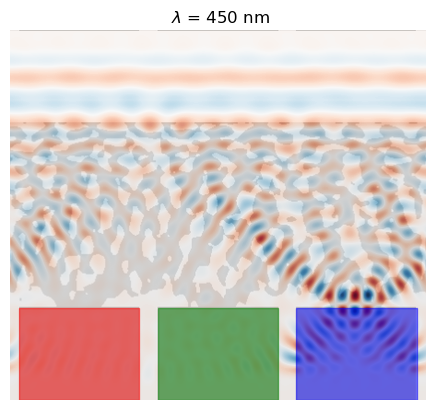

In [14]:
###############################################################################################################################

# ## 3. result plot

# blue pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[5], fwidth=fwidth_blue, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, )]
opt.sim.change_sources(source)

plt.figure()

plt.title(' $\lambda$ = 450 nm')
opt.sim.run(until=50)
plt.fill([design_region_width/6+dti/2, design_region_width/6+dti/2, design_region_width/2-dti/2, design_region_width/2-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='blue', alpha=0.5)
plt.fill([-design_region_width/6+dti/2, -design_region_width/6+dti/2, design_region_width/6-dti/2, design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='green', alpha=0.5)
plt.fill([-design_region_width/2+dti/2, -design_region_width/2+dti/2, -design_region_width/6-dti/2, -design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='red', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0},
               # eps_parameters={'alpha':0},
               # field_parameters={'colorbar':True}
          )
plt.axis("off")

plt.savefig(design_dir+"EzBlue.png")


-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 2D dimensions.
Computational cell is 9 x 8 x 0 with resolution 50
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.900732 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 95.79/100.0 = 95.8% done in 4.0s, 0.2s to go
on time step 9581 (time=95.81), 0.000417511 s/step
run 0 finished at t = 100.0 (10000 timesteps)
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


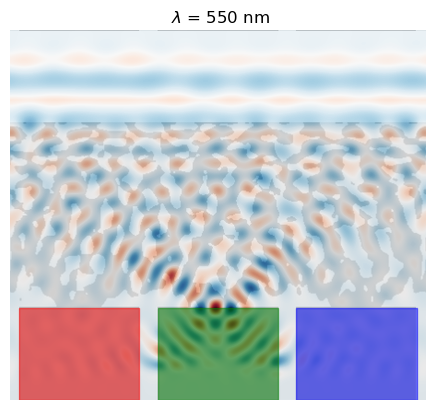

In [15]:
# green pixel


# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[15], fwidth=fwidth_green, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure()

plt.title(' $\lambda$ = 550 nm')
opt.sim.run(until=100)
plt.fill([design_region_width/6+dti/2, design_region_width/6+dti/2, design_region_width/2-dti/2, design_region_width/2-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='blue', alpha=0.5)
plt.fill([-design_region_width/6+dti/2, -design_region_width/6+dti/2, design_region_width/6-dti/2, design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='green', alpha=0.5)
plt.fill([-design_region_width/2+dti/2, -design_region_width/2+dti/2, -design_region_width/6-dti/2, -design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='red', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0},
               # eps_parameters={'alpha':0},
               # field_parameters={'colorbar':True}
          )
plt.axis("off")
plt.savefig(design_dir+"EzGreen.png")


-----------
Initializing structure...
time for choose_chunkdivision = 4.72069e-05 s
Working in 2D dimensions.
Computational cell is 9 x 8 x 0 with resolution 50
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.907453 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 96.05/100.0 = 96.0% done in 4.0s, 0.2s to go
on time step 9608 (time=96.08), 0.000416327 s/step
run 0 finished at t = 100.0 (10000 timesteps)
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


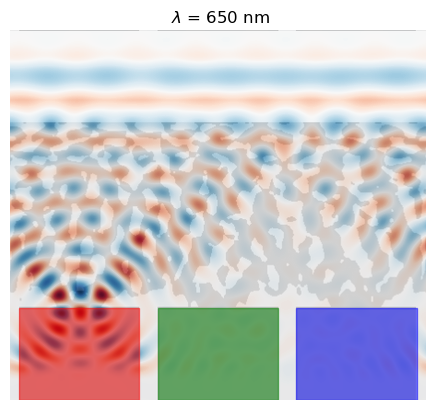

In [16]:
# red pixel


# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[25], fwidth=fwidth_red, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure()

plt.title(' $\lambda$ = 650 nm')
opt.sim.run(until=100)
plt.fill([design_region_width/6+dti/2, design_region_width/6+dti/2, design_region_width/2-dti/2, design_region_width/2-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='blue', alpha=0.5)
plt.fill([-design_region_width/6+dti/2, -design_region_width/6+dti/2, design_region_width/6-dti/2, design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='green', alpha=0.5)
plt.fill([-design_region_width/2+dti/2, -design_region_width/2+dti/2, -design_region_width/6-dti/2, -design_region_width/6-dti/2], [-Sy/2, -Sy/2+PDsize, -Sy/2+PDsize, -Sy/2], color='red', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0},
               # eps_parameters={'alpha':0},
               # field_parameters={'colorbar':True}
          )
plt.axis("off")
 
plt.savefig(design_dir+"EzRed.png")



     block, center = (0,0,0)
          size (9,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


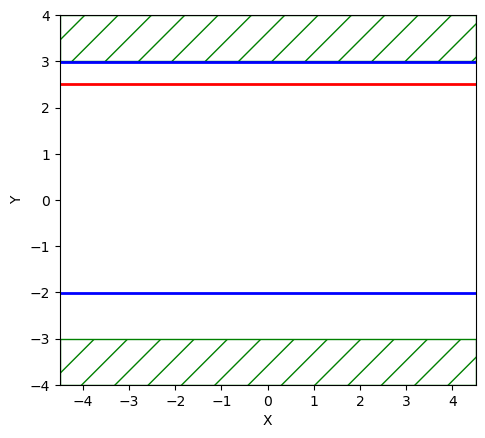

In [17]:
###############################################################################################################################
# ## 5. Optical Efficiency

opt.sim.reset_meep()

# simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]


opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution, 
    k_point = mp.Vector3(0,0,0)
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)


tran_t = mp.FluxRegion(
    center=mp.Vector3(0, -Sy/2 + PDsize - 0.5/resolution, 0), size=mp.Vector3(Sx, 0, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, Sy/2 - Lpml - 0.5/resolution, 0), size=mp.Vector3(Sx, 0, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

pt = mp.Vector3(1, -Sy/2 + PDsize + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.plot2D()

In [18]:
opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9, 0))

straight_refl_data = sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)
 

opt.sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 2D dimensions.
Computational cell is 9 x 8 x 0 with resolution 50
     block, center = (0,0,0)
          size (9,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.223216 s
-----------
run 0 finished at t = 24.310000000000002 (2431 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 4.88758e-05 s
Working in 2D dimensions.
Computational cell is 9 x 8 x 0 with resolution 50
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (9,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (0,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
     block, center = (3,-3,0)
          size (2.6,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.909714 s
-----------
     block, center = (0,0,0)
          size (9,4,0)
          axes (1,0,0), (0,1,0)

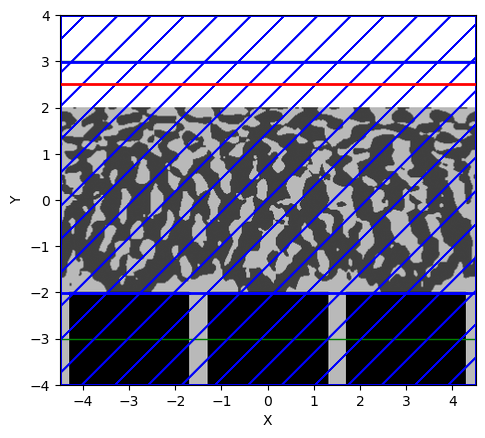

In [19]:
# simulation 2 : geometry가 있는 구조
 
opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution, 
    k_point = mp.Vector3(0,0,0)
)
 
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran = opt.sim.add_flux(fcen, df, nfreq, tran_t)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.
sim.load_minus_flux_data(refl, straight_refl_data)


tran_r = mp.FluxRegion(
    center=mp.Vector3(-design_region_width/3, -Sy/2 + PDsize - 0.5/resolution, 0), size=mp.Vector3(subpixelsize, 0, 0)
)
tran_g = mp.FluxRegion(
    center=mp.Vector3(0, -Sy/2 + PDsize - 0.5/resolution, 0), size=mp.Vector3(subpixelsize, 0, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(design_region_width/3, -Sy/2 + PDsize - 0.5/resolution, 0), size=mp.Vector3(subpixelsize, 0, 0)
)

tran_Ex = opt.sim.add_dft_fields([mp.Ex], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], fcen, df , nfreq, center=mp.Vector3(0, 0, 0), size=mp.Vector3(design_region_width, Sy, 0), yee_grid=True)

tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
opt.plot2D()

In [20]:
opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9, 0))

red_flux = mp.get_fluxes(tran_red)
green_flux = mp.get_fluxes(tran_green)
blue_flux = mp.get_fluxes(tran_blue)

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)


on time step 540 (time=5.4), 0.00756019 s/step
on time step 1080 (time=10.8), 0.00752922 s/step
on time step 1621 (time=16.21), 0.00742837 s/step
on time step 2188 (time=21.88), 0.00706092 s/step
on time step 2736 (time=27.36), 0.00744936 s/step
on time step 3276 (time=32.76), 0.00749091 s/step
on time step 3816 (time=38.16), 0.00743078 s/step
on time step 4375 (time=43.75), 0.00726764 s/step
on time step 4942 (time=49.42), 0.00724568 s/step
on time step 5508 (time=55.08), 0.00718726 s/step
on time step 6048 (time=60.48), 0.00746018 s/step
on time step 6588 (time=65.88), 0.00754245 s/step
on time step 7129 (time=71.29), 0.00743499 s/step
on time step 7696 (time=76.96), 0.00712509 s/step
on time step 8244 (time=82.44), 0.0074738 s/step
on time step 8784 (time=87.84), 0.00764304 s/step
on time step 9324 (time=93.24), 0.00756452 s/step
on time step 9900 (time=99), 0.00724462 s/step
on time step 10450 (time=104.5), 0.00732774 s/step
on time step 11016 (time=110.16), 0.00717446 s/step
on ti

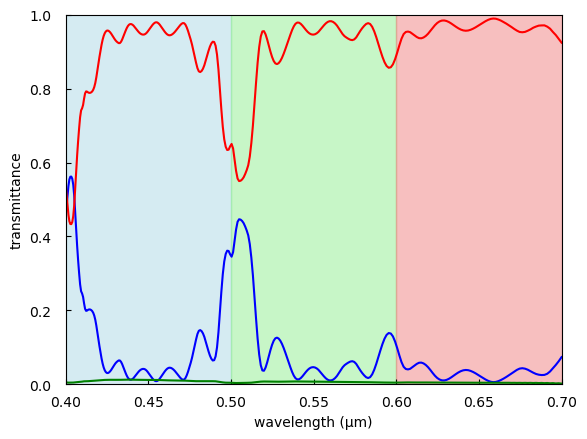

In [21]:
# 투과율과 반사율


wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure()
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0.0, 1.0])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [-0.03, 1.03, 1.03, -0.03], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [-0.03, 1.03, 1.03, -0.03], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [-0.03, 1.03, 1.03, -0.03], color='lightcoral', alpha=0.5)
    plt.tick_params(axis='x', direction='in', pad = 8)
    plt.tick_params(axis='y', direction='in', pad = 10)
    # plt.legend(loc="right")
    #plt.show()
    plt.savefig(design_dir+"T_R.png")

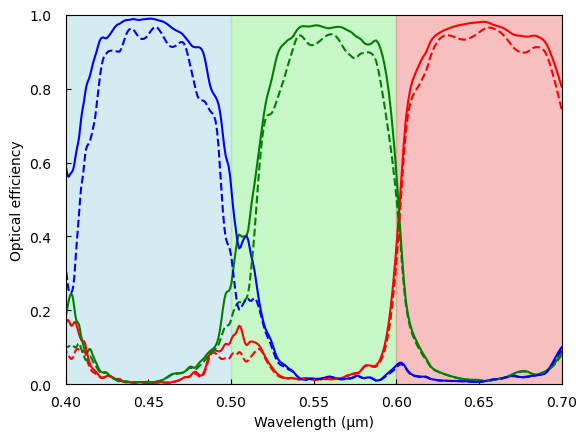

In [22]:
# 입사 flux 대비 효율


wl = []
Tr = []
Tg = []
Tb = []

Trt = []
Tgt = []
Tbt = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / tran_flux[i] )
    Tg = np.append(Tg, green_flux[i] / tran_flux[i] )
    Tb = np.append(Tb, blue_flux[i] / tran_flux[i] )
    
    Trt = np.append(Trt, red_flux[i] / total_flux[i])
    Tgt = np.append(Tgt, green_flux[i] / total_flux[i])
    Tbt = np.append(Tbt, blue_flux[i] / total_flux[i])


if mp.am_master():
    plt.figure()
    plt.plot(wl, Tr, "r", label="red subpixel power / transmitted power")
    plt.plot(wl, Tg, "g", label="green subpixel power / transmitted power")
    plt.plot(wl, Tb, "b", label="blue subpixel power / transmitted power")
    plt.plot(wl, Trt, "r--", label="red subpixel power / incident power")
    plt.plot(wl, Tgt, "g--", label="green subpixel power / incident power")
    plt.plot(wl, Tbt, "b--", label="blue subpixel power / incident power")

    
    plt.axis([0.40, 0.70, 0, 1.0])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Optical efficiency")
    plt.fill([0.40, 0.40, 0.50, 0.50], [-0.03, 1.03, 1.03, -0.03], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [-0.03, 1.03, 1.03, -0.03], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [-0.03, 1.03, 1.03, -0.03], color='lightcoral', alpha=0.5)
    plt.tick_params(axis='x', direction='in', pad = 8)
    plt.tick_params(axis='y', direction='in', pad = 10)
    # plt.legend(loc='upper right', bbox_to_anchor=(1.1,-0.2))
    plt.savefig(design_dir+"Optical_efficiency.png",bbox_inches='tight')
 


In [23]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tb[160:300]))

0.912245372452239
0.8093939360912429
0.8741119774620966


In [24]:
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tb[160:300]))

0.9809095418704612
0.9713336049779132
0.9893767473209117


In [25]:
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))

0.9716657735494404
0.9589032313538979
0.9867341900496748


In [26]:
print(np.mean(Tr[66:300]))

0.053988419360885005


In [27]:
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)

0.06451515963924574


In [28]:
print(np.mean(Tb[0:160]))

0.07231384998398116


In [29]:
from matplotlib.colors import LinearSegmentedColormap
gray_color = '#b9b9b9'
black_color = '#404040'

# Create a custom colormap from 'gray' to 'black'
cmap = LinearSegmentedColormap.from_list('gray_to_black', [gray_color, black_color])


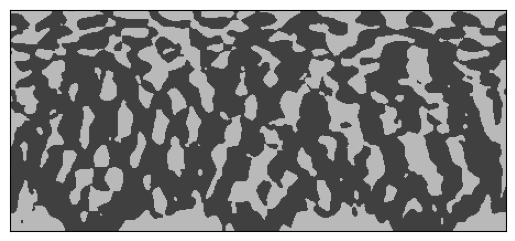

In [30]:
plt.imshow(npa.rot90(structure_weight.reshape(Nx, Ny)), cmap=cmap)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.savefig(design_dir+"design.png")

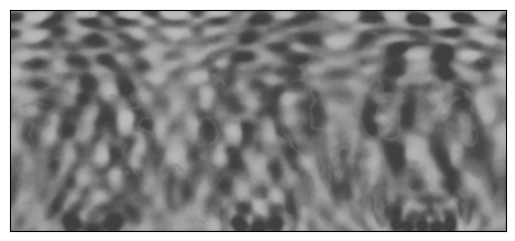

In [31]:
structure_weight10 = np.loadtxt('structure_010.txt')
plt.imshow(npa.rot90(structure_weight10.reshape(Nx, Ny)), cmap=cmap)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.savefig(design_dir+"design10.png")

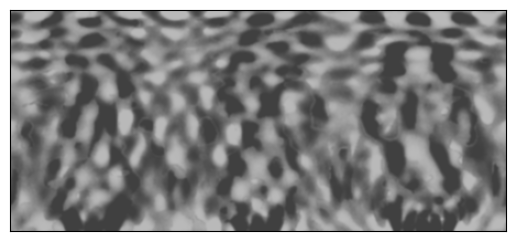

In [32]:
structure_weight20 = np.loadtxt('structure_020.txt')
plt.imshow(npa.rot90(structure_weight20.reshape(Nx, Ny)), cmap=cmap)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.savefig(design_dir+"design20.png")

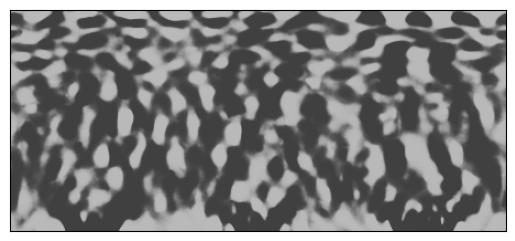

In [33]:
structure_weight60 = np.loadtxt('structure_060.txt')
plt.imshow(npa.rot90(structure_weight60.reshape(Nx, Ny)), cmap=cmap)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.savefig(design_dir+"design60.png")

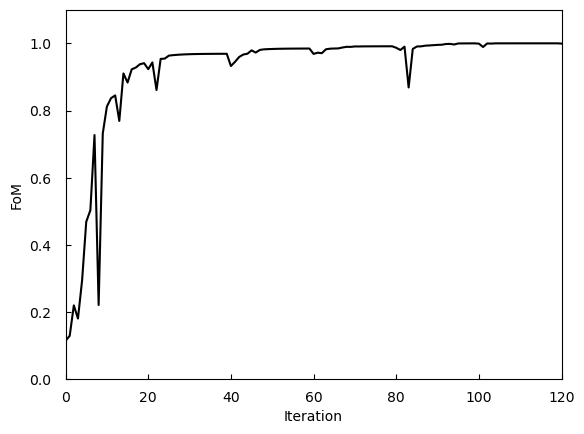

In [34]:

evaluation_history = np.loadtxt('evaluation.txt')

# FoM plot

plt.figure()

plt.plot(evaluation_history/max(evaluation_history), "k-")
plt.grid(False)
plt.axis([0, 120, 0, 1.1])
plt.tick_params(axis='x', direction='in', pad = 8)
plt.tick_params(axis='y', direction='in', pad = 10)
plt.xlabel("Iteration")
plt.ylabel("FoM")

plt.savefig(design_dir+"FoMresult.png")

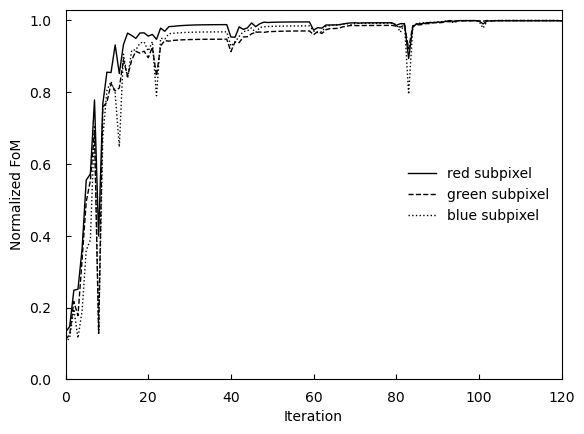

In [35]:
fred = np.loadtxt('fred.txt')
fgreen = np.loadtxt('fgreen.txt')
fblue = np.loadtxt('fblue.txt')

plt.figure()

# plt.plot(evaluation_history/max(evaluation_history), "k-",label='total pixel')
plt.plot(fred/max(fred), "k-",label='red subpixel', linewidth='1')
plt.plot(fgreen/max(fgreen), "k--",label='green subpixel', linewidth='1')
plt.plot(fblue/max(fblue), "k:",label='blue subpixel', linewidth='1')
plt.grid(False)
plt.axis([0, 120, 0, 1.03])
plt.tick_params(axis='x', direction='in', pad = 8)
plt.tick_params(axis='y', direction='in', pad = 10)
plt.xlabel("Iteration")
plt.ylabel("Normalized FoM")
plt.legend(loc='right',frameon=False)
plt.savefig('temp.svg', transparent=True)


In [36]:
params = {
    'axes.labelsize':9, # label 폰트 크기
    'axes.titlesize':9, # 타이틀 폰트 크기
    'xtick.labelsize':9, # x 축 tick label 폰트 크기
    'ytick.labelsize':9, # y 축 tick label 폰트 크기 
    'xtick.direction': 'in', # 눈금 표시 방향 (in, out, inout)
    'ytick.direction': 'in', # 눈금 표시 방향 (in, out, inout)
    'lines.markersize': 3, # 마커 사이즈
    'axes.titlepad': 6, # 타이틀과 그래프 사이의 간격
    'axes.labelpad': 4, # 축 label과 그래프 사이의 간격
    'font.size': 9, # font 크기
    'font.sans-serif': 'Arial', # font 설정
    'figure.dpi': 300, # 해상도, vector그래픽의 경우 dpi에 상관없이 깔끔하게 출력됨
    'figure.autolayout': True, # 레이아웃 자동 설정 (그래프의 모든 요소가 figure 내부에 들어가도록 설정)
    'xtick.top': True, # 그래프 위쪽 x축 눈금 표시
    'ytick.right': True, # 그래프 오른쪽 y축 눈금 표시
    'xtick.major.size': 2, # x축 눈금의 길이
    'ytick.major.size': 2, # y축 눈금의 길이
}
plt.rcParams.update(params)